#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행 
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
        * 성능 가이드
            * Accuracy : 0.900~0.968

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 1) 로컬 수행(Ananconda)
            * 제공된 압축파일을 다운받아 압축을 풀고
            * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
        * 2) 구글콜랩
            * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
            * 데이터 파일을 복사해 넣습니다.
    
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다. 
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [17]:
path = 'C:/Users/User/Desktop/'

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
# path = '/content/drive/MyDrive/project/'

### (2) 라이브러리 불러오기

#### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import *


# 필요하다고 판단되는 라이브러리를 추가하세요.

#### 2) 제공 함수 생성
* 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
* 입력 : 
    * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
    * names : 변수 이름 목록(예 : x_train.columns
    * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
    * topn : 중요도 상위 n개만 표시. all 이면 전체.
* 출력 : 
    * 중요도 그래프 : 중요도 내림차순으로 정렬
    * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [4]:
data = pd.read_csv('data01_train.csv')
test = pd.read_csv('data01_test.csv')
features = pd.read_csv('features.csv')

In [5]:
data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [6]:
data.shape

(5881, 562)

In [7]:
data.head(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING


In [8]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [9]:
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다. 


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [10]:
target = 'Activity'
x = data.drop(target, axis = 1)
y = data[target]

### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.3, random_state=1)

In [16]:
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x_s, y, test_size = 0.3, random_state = 1)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다. 
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.

### (1) Random Forest Classifier

#### 1) 전체 변수

In [17]:
model_rf = RandomForestClassifier()

model_rf.fit(x_train, y_train)
pred_rf = model_rf.predict(x_val)

print('accuracy :',accuracy_score(y_val, pred_rf))
print('='*60)
print(confusion_matrix(y_val, pred_rf))
print('='*60)
print(classification_report(y_val, pred_rf))

accuracy : 0.9779036827195468
[[329   0   0   0   0   2]
 [  0 279  13   0   0   0]
 [  0  11 320   0   0   0]
 [  0   0   0 293   2   2]
 [  0   0   0   1 235   3]
 [  0   0   0   0   5 270]]
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       331
           SITTING       0.96      0.96      0.96       292
          STANDING       0.96      0.97      0.96       331
           WALKING       1.00      0.99      0.99       297
WALKING_DOWNSTAIRS       0.97      0.98      0.98       239
  WALKING_UPSTAIRS       0.97      0.98      0.98       275

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



In [19]:
r = plot_feature_importance(model_rf.feature_importances_, list(x_train), True)
r.head()

,feature_name,feature_importance
0,tGravityAcc-mean()-X,0.029840
1,tGravityAcc-max()-X,0.028912
2,tGravityAcc-max()-Y,0.028839
3,"angle(X,gravityMean)",0.027897
4,tGravityAcc-min()-X,0.027786


#### 2) (옵션)적절히 선택한 변수
* 변수 중요도 상위 100로 결정해서 모델링 해보기
* 변수 중요도 상위 1 ~ 400 까지 변수를 하나씩 늘려가며 모델링 및 성능 비교

In [20]:
feature100 = r.loc[:99, 'feature_name']

x_train100 = x_train[feature100]
x_val100 = x_val[feature100]

model_rf100 = RandomForestClassifier()

model_rf100.fit(x_train100, y_train)
pred_rf100 = model_rf100.predict(x_val100)

print('accuracy :',accuracy_score(y_val, pred_rf100))
print('='*60)
print(confusion_matrix(y_val, pred_rf100))
print('='*60)
print(classification_report(y_val, pred_rf100))

accuracy : 0.9784702549575071
[[331   0   0   0   0   0]
 [  0 280  12   0   0   0]
 [  0  13 318   0   0   0]
 [  0   0   0 292   2   3]
 [  0   0   0   4 232   3]
 [  0   0   0   0   1 274]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       331
           SITTING       0.96      0.96      0.96       292
          STANDING       0.96      0.96      0.96       331
           WALKING       0.99      0.98      0.98       297
WALKING_DOWNSTAIRS       0.99      0.97      0.98       239
  WALKING_UPSTAIRS       0.98      1.00      0.99       275

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



* 가장 중요한 변수부터 하나씩 증가시켜가며 모델링 및 accuracy 구하기

In [21]:
acc = []

for i in range(50) :   # 전체 변수는 561이지만, 50 정도면 충분
    featureN = r.loc[:i, 'feature_name']
    x_trainN = x_train[featureN]
    x_valN = x_val[featureN]
    m = RandomForestClassifier()
    m.fit(x_trainN, y_train)
    p = m.predict(x_valN)
    acc.append(accuracy_score(y_val, p))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


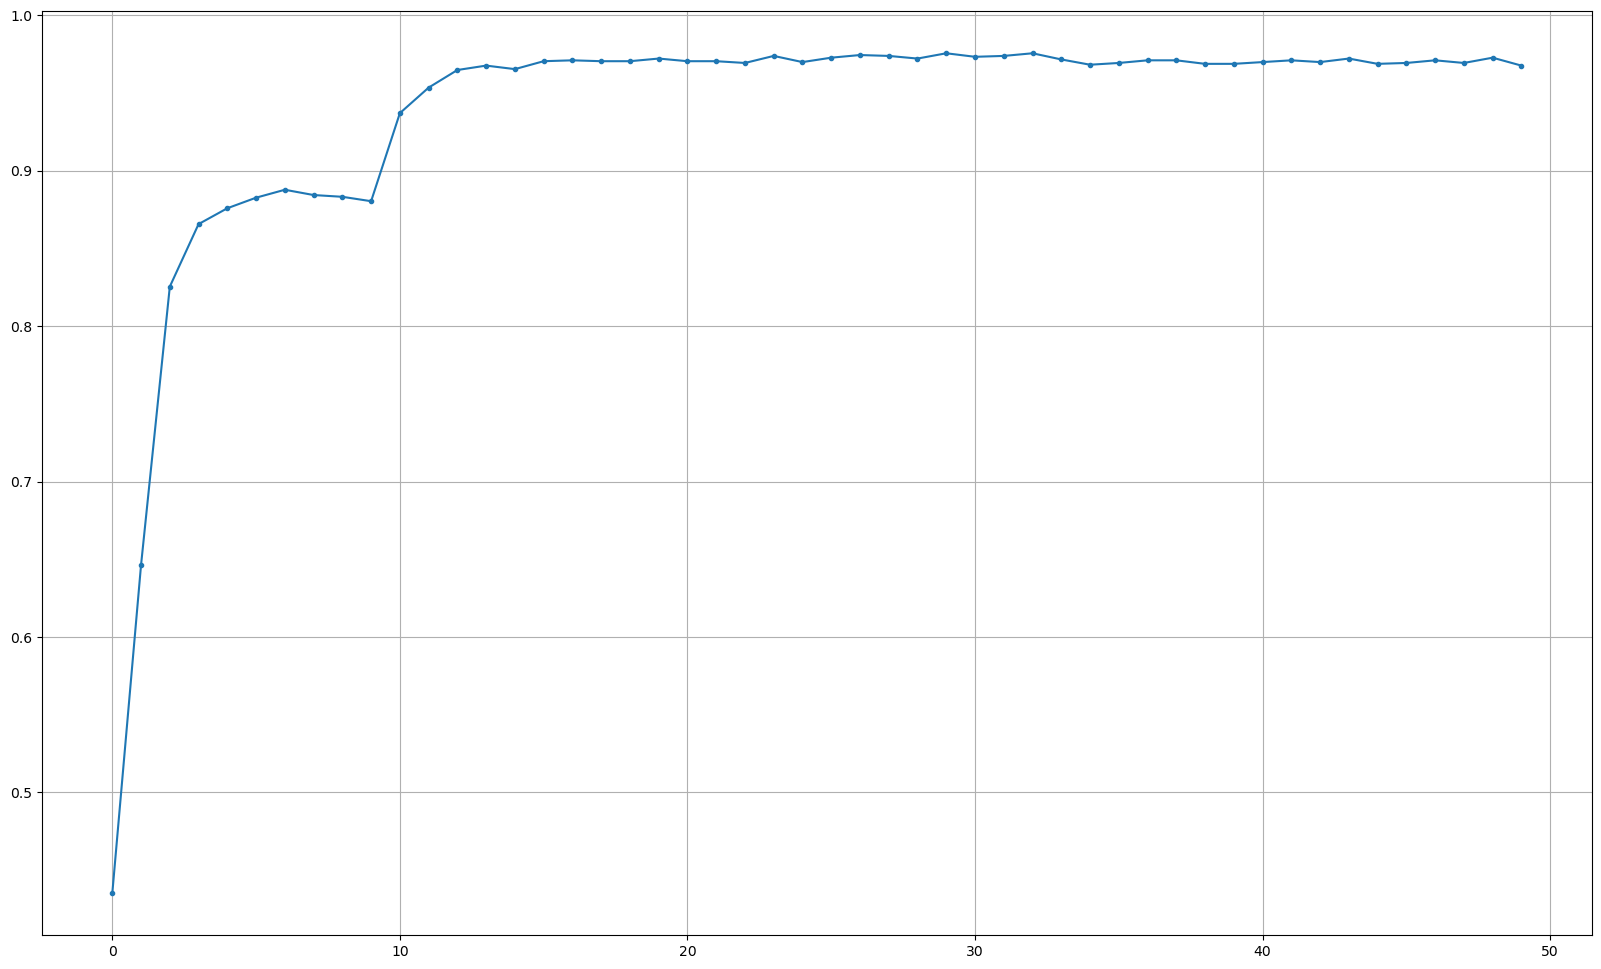

In [23]:
plt.figure(figsize = (20,12))
plt.plot(range(50), acc, marker = '.')
plt.grid()
plt.show()
# 15개도 충분해 보임

* 적절한 지점의 성능에 맞춰 변수 선택 : ==> 30~50개 정도면 충분!

In [22]:
# 변수 30개 선택 
feature30 = r.loc[:29, 'feature_name']
x_train30 = x_train[feature30]
x_val30 = x_val[feature30]

model_rf30 = RandomForestClassifier()
model_rf30.fit(x_train30, y_train)
pred_rf30 = model_rf30.predict(x_val30)

print('accuracy :',accuracy_score(y_val, pred_rf30))
print('='*60)
print(confusion_matrix(y_val, pred_rf30))
print('='*60)
print(classification_report(y_val, pred_rf30))

accuracy : 0.9716713881019831
[[331   0   0   0   0   0]
 [  0 284   8   0   0   0]
 [  0  18 313   0   0   0]
 [  0   0   0 290   4   3]
 [  0   0   0   7 227   5]
 [  0   0   0   2   3 270]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       331
           SITTING       0.94      0.97      0.96       292
          STANDING       0.98      0.95      0.96       331
           WALKING       0.97      0.98      0.97       297
WALKING_DOWNSTAIRS       0.97      0.95      0.96       239
  WALKING_UPSTAIRS       0.97      0.98      0.98       275

          accuracy                           0.97      1765
         macro avg       0.97      0.97      0.97      1765
      weighted avg       0.97      0.97      0.97      1765



### (2) Logistic Regressin

#### 1) 전체 변수

In [24]:
model_lr = LogisticRegression()

model_lr.fit(x_train, y_train)
pred_lr = model_lr.predict(x_val)

print('accuracy :',accuracy_score(y_val, pred_lr))
print('='*60)
print(confusion_matrix(y_val, pred_lr))
print('='*60)
print(classification_report(y_val, pred_lr))

accuracy : 0.9818696883852691
[[331   0   0   0   0   0]
 [  0 281  11   0   0   0]
 [  0  16 315   0   0   0]
 [  0   0   0 297   0   0]
 [  0   0   0   2 235   2]
 [  0   0   0   1   0 274]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       331
           SITTING       0.95      0.96      0.95       292
          STANDING       0.97      0.95      0.96       331
           WALKING       0.99      1.00      0.99       297
WALKING_DOWNSTAIRS       1.00      0.98      0.99       239
  WALKING_UPSTAIRS       0.99      1.00      0.99       275

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 2) (옵션)적절히 선택한 변수
* 변수 중요도 상위 100로 모델링 해보기

In [26]:
feature100 = r.loc[:99, 'feature_name']

x_train100 = x_train[feature100]
x_val100 = x_val[feature100]

model_lr100 = LogisticRegression()

model_lr100.fit(x_train100, y_train)
pred_lr100 = model_lr100.predict(x_val100)

print('accuracy :',accuracy_score(y_val, pred_lr100))
print('='*60)
print(confusion_matrix(y_val, pred_lr100))
print('='*60)
print(classification_report(y_val, pred_lr100))

accuracy : 0.9614730878186969
[[330   1   0   0   0   0]
 [  0 264  28   0   0   0]
 [  0  28 303   0   0   0]
 [  0   0   0 294   1   2]
 [  0   0   0   2 233   4]
 [  0   0   0   2   0 273]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       331
           SITTING       0.90      0.90      0.90       292
          STANDING       0.92      0.92      0.92       331
           WALKING       0.99      0.99      0.99       297
WALKING_DOWNSTAIRS       1.00      0.97      0.99       239
  WALKING_UPSTAIRS       0.98      0.99      0.99       275

          accuracy                           0.96      1765
         macro avg       0.96      0.96      0.96      1765
      weighted avg       0.96      0.96      0.96      1765



C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### (3) SVM

#### 1) kernel = 'rbf'

In [27]:
model_k = SVC(C=1, gamma=0.01, kernel = 'rbf', random_state=2022) 
model_k.fit(x_train, y_train)
pred_k = model_k.predict(x_val)

print('accuracy :',accuracy_score(y_val, pred_k))
print('='*60)
print(confusion_matrix(y_val, pred_k))
print('='*60)
print(classification_report(y_val, pred_k))

accuracy : 0.9739376770538244
[[331   0   0   0   0   0]
 [  0 271  21   0   0   0]
 [  0  24 307   0   0   0]
 [  0   0   0 297   0   0]
 [  0   0   0   0 239   0]
 [  0   0   0   1   0 274]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       331
           SITTING       0.92      0.93      0.92       292
          STANDING       0.94      0.93      0.93       331
           WALKING       1.00      1.00      1.00       297
WALKING_DOWNSTAIRS       1.00      1.00      1.00       239
  WALKING_UPSTAIRS       1.00      1.00      1.00       275

          accuracy                           0.97      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.97      0.97      0.97      1765



#### 2) kernel = 'linear'

In [28]:
model_l = SVC(C=1, gamma=0.01, kernel = 'linear', random_state=2022) 
model_l.fit(x_train, y_train)
pred_l = model_l.predict(x_val)

print('accuracy :',accuracy_score(y_val, pred_l))
print('='*60)
print(confusion_matrix(y_val, pred_l))
print('='*60)
print(classification_report(y_val, pred_l))

accuracy : 0.9875354107648725
[[331   0   0   0   0   0]
 [  0 286   6   0   0   0]
 [  0  16 315   0   0   0]
 [  0   0   0 297   0   0]
 [  0   0   0   0 239   0]
 [  0   0   0   0   0 275]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       331
           SITTING       0.95      0.98      0.96       292
          STANDING       0.98      0.95      0.97       331
           WALKING       1.00      1.00      1.00       297
WALKING_DOWNSTAIRS       1.00      1.00      1.00       239
  WALKING_UPSTAIRS       1.00      1.00      1.00       275

          accuracy                           0.99      1765
         macro avg       0.99      0.99      0.99      1765
      weighted avg       0.99      0.99      0.99      1765



### (4) XGB

In [30]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# xgb는 target이 문자면 안됨, 숫자로 라벨인코딩 실시 
label_encoder = LabelEncoder()

# 훈련 및 검증 데이터의 대상 클래스를 정수로 변환
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train_encoded)
pred_xgb = model_xgb.predict(x_val)

print('accuracy :',accuracy_score(y_val_encoded, pred_xgb))
print('='*60)
print(confusion_matrix(y_val_encoded, pred_xgb))
print('='*60)
print(classification_report(y_val_encoded, pred_xgb))

accuracy : 0.9932011331444759
[[331   0   0   0   0   0]
 [  0 288   4   0   0   0]
 [  0   5 326   0   0   0]
 [  0   0   0 296   1   0]
 [  0   0   0   1 237   1]
 [  0   0   0   0   0 275]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       0.98      0.99      0.98       292
           2       0.99      0.98      0.99       331
           3       1.00      1.00      1.00       297
           4       1.00      0.99      0.99       239
           5       1.00      1.00      1.00       275

    accuracy                           0.99      1765
   macro avg       0.99      0.99      0.99      1765
weighted avg       0.99      0.99      0.99      1765



In [32]:
# # 결과를 다시 원래 클래스로 디코딩하고 사용할 수 있습니다.
# pred_xgb_decoded = label_encoder.inverse_transform(pred_xgb)
# pred_xgb_decoded[:10]

array(['SITTING', 'SITTING', 'SITTING', 'WALKING_UPSTAIRS',
       'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS', 'LAYING',
       'WALKING_DOWNSTAIRS', 'STANDING', 'LAYING'], dtype=object)

### (5) light gbm

In [40]:
x_train2 = x_train.copy()
x_val2 = x_val.copy()


In [41]:
x_train2.head(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
2196,0.273709,-0.018918,-0.113927,-0.997142,-0.994221,-0.988164,-0.997195,-0.994357,-0.990993,-0.943987,...,-0.254744,-0.487267,-0.874982,0.111883,-0.396258,-0.308503,-0.244304,0.409907,-0.725955,0.273716
1603,0.252686,-0.024835,-0.064154,0.067493,0.007643,-0.282478,0.001899,-0.074320,-0.233337,0.500089,...,0.058606,-0.436182,-0.808152,0.209394,-0.310778,0.950980,0.444218,-0.985944,0.089186,0.008116


In [42]:
# light gbm은 컬럼명에 json이 인식하지 못하는 문자가 있으면 안됨 
x_train2 = x_train.copy()
x_val2 = x_val.copy()

x_train2.columns = [col.replace("-", "_") for col in x_train2.columns]
x_train2.columns = [col.replace("(", "") for col in x_train2.columns]
x_train2.columns = [col.replace("(", "") for col in x_train2.columns]
x_train2.columns = [col.replace(",", "_") for col in x_train2.columns]

x_val2.columns = [col.replace("-", "_") for col in x_val2.columns]
x_val2.columns = [col.replace("(", "") for col in x_val2.columns]
x_val2.columns = [col.replace("(", "") for col in x_val2.columns]
x_val2.columns = [col.replace(",", "_") for col in x_val2.columns]

In [45]:
from lightgbm import LGBMClassifier

model_gbm = LGBMClassifier(verbose=-1)
model_gbm.fit(x_train2, y_train)
pred_gbm = model_gbm.predict(x_val2)

print('accuracy :',accuracy_score(y_val, pred_gbm))
print('='*60)
print(confusion_matrix(y_val, pred_gbm))
print('='*60)
print(classification_report(y_val, pred_gbm))

accuracy : 0.9926345609065156
[[331   0   0   0   0   0]
 [  0 287   5   0   0   0]
 [  0   6 325   0   0   0]
 [  0   0   0 296   1   0]
 [  0   0   0   0 238   1]
 [  0   0   0   0   0 275]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       331
           SITTING       0.98      0.98      0.98       292
          STANDING       0.98      0.98      0.98       331
           WALKING       1.00      1.00      1.00       297
WALKING_DOWNSTAIRS       1.00      1.00      1.00       239
  WALKING_UPSTAIRS       1.00      1.00      1.00       275

          accuracy                           0.99      1765
         macro avg       0.99      0.99      0.99      1765
      weighted avg       0.99      0.99      0.99      1765



#### 3) 하이퍼파라미터 튜닝

* test 전체 수행하기(12 ~ 15분 소요)

In [57]:
# 딕셔너리 형태로 관심있는 매개변수의 그리드 설정하기
param_grid = {'C': [0.01, 1, 100],
             'gamma': [0.0001, 0.001, 0.1, 1],
             'kernel': ['linear', 'rbf'] }

#생성
# refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재학습시킴. 
model_svc = SVC() 
model_final = GridSearchCV(model_svc, param_grid, return_train_score=True, cv=5) #cross-validation 옵션 추가? cv=5

#학습
# train data로 param_grid의 하이퍼 파라미터들을 순차적으로 학습/평가 .
model_final.fit(x_train, y_train)

#결과
# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(model_final.cv_results_)

In [ ]:
print('최적파라미터:', model_final.best_params_)
print('='*60)
print('최고성능:', model_final.best_score_)
print('='*60)

* 예측 및 평가

In [59]:
pred_final = model_final.predict(x_val)

In [ ]:
print('accuracy :',accuracy_score(y_val, pred_final))
print('='*60)
print(confusion_matrix(y_val, pred_final))
print('='*60)
print(classification_report(y_val, pred_final))